# Example of reading in 3D spectral cube data and plotting

Notes: 

- <b>Fits files</b> are nimary files that are very popular in astronomy. They contain two parts: header - with information on the content of the file. Typically details on the data properties, the observation and the data processing. The second part is the data itself, which is mostly image data. There can be several images stored in one file, or even 3D data.

    - It is also possible to store data tables in fits files. 
    
- "j104540-2927_cube_v2.fits" is the file that contains the 3D data cube. This is an observation with the Australia Telescope Compact Array (ATCA) of a distant radio continuum source, where we are interested in the neutral hydrogen (HI) absorption in the inter stellar medium (ISM) of our own Galaxy.

In [1]:
# import libraries

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy 
from astropy.wcs import WCS
from astropy.time import Time
import pandas as pd
import os
from astropy.modeling import models, fitting
from astropy.modeling.models import Gaussian1D

# define some parameters for prettier plots

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline

INFO: Auto-setting vmin to -4.033e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.464e+04 [aplpy.core]


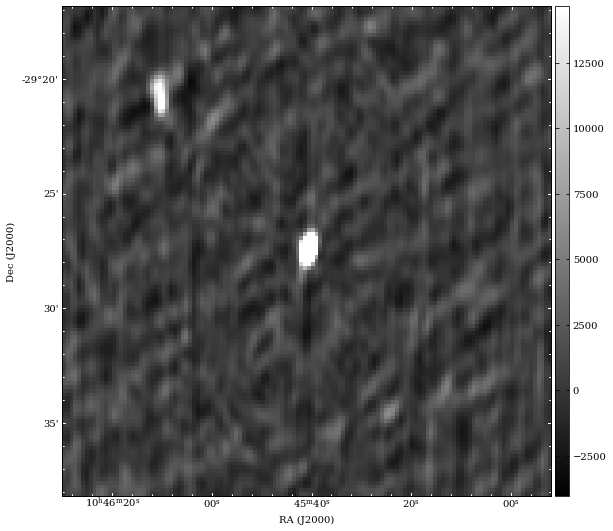

In [2]:
# read in the data from the file

cube = SpectralCube.read('j104540-2927_cube_v2.fits')  # Open the FITS file for reading


# have a look at the data inside the data cube
cube.moment0(axis=0).quicklook()


In [3]:
# open the 3D data file with a different method and put the data and the header information into objects

atca = fits.open('j104540-2927_cube_v2.fits')  # Open the FITS file for reading
d_atca = atca[0].data
h_atca = atca[0].header
w_atca = WCS(h_atca, atca)


In [4]:
# get the coordinate of the centre of the imgage from the header

c_atca = SkyCoord(ra=h_atca['CRVAL1'], dec=h_atca['CRVAL2'], unit=(u.deg, u.deg))
pixels_atca = c_atca.to_pixel(w_atca)


In [5]:
# check the coordinates:

c_atca

<SkyCoord (ICRS): (ra, dec) in deg
    (161.41916666, -29.45722221)>

In [6]:
# extract the spectrom from the central pixel, where the continuum source is

spectrum = cube[:, int(pixels_atca[1]), int(pixels_atca[0])] 


In [7]:
# define the spectral axis:

vel = np.array(cube.spectral_axis)


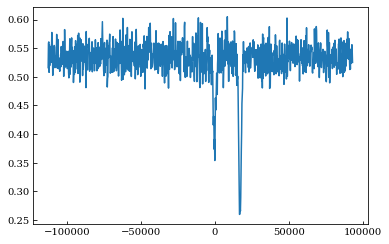

In [8]:
# check the spectra:

plt.plot(vel, spectrum)

In [9]:
# A very simple fit to the continuum emission

pars = np.polyfit(vel, spectrum, 1)
print(pars)

[-3.03314661e-08  5.30486135e-01]


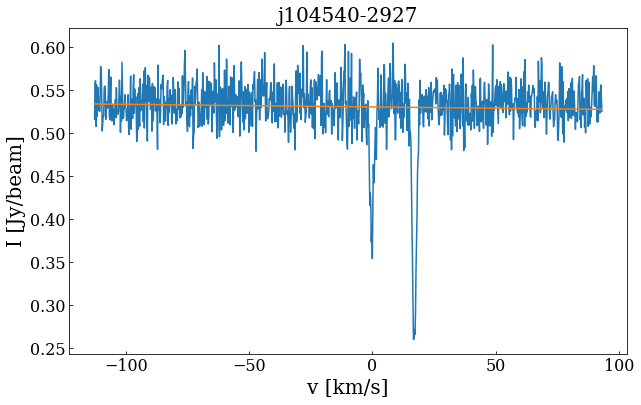

In [10]:
fig, ax=plt.subplots(figsize = (10,6))
plt.title('j104540-2927', fontsize=20)
plt.plot(vel/1000, spectrum)
plt.plot(vel/1000, vel*pars[0]+pars[1])
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'I [Jy/beam]', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

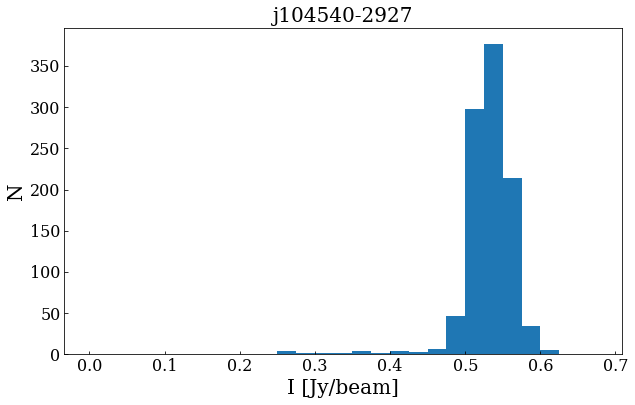

In [11]:
# A better fit can be achived with masking the absorption lines
# first, let us find a good data range for the mask

# Makeing a plot:

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j104540-2927', fontsize=20)
plt.hist(np.array(spectrum), bins=np.arange(0,0.7,0.025))
ax.set_ylabel(r'N', fontsize=20)
ax.set_xlabel(r'I [Jy/beam]', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

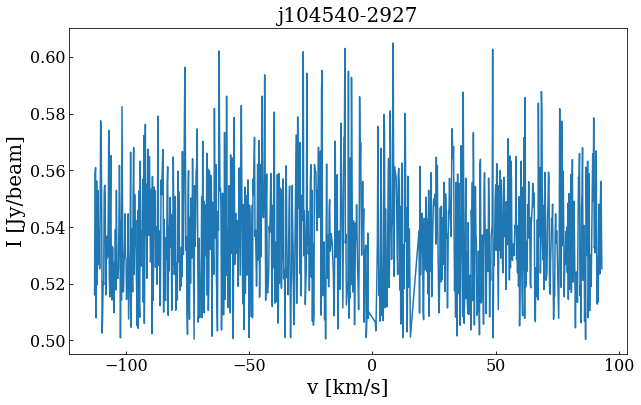

In [12]:
# masking the data
spectrum = np.array(spectrum)

spectrum_masked = spectrum[spectrum > 0.5]
index = np.where(spectrum > 0.5)
#print(index)
vel_masked = vel[index]


# Makeing a plot:

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j104540-2927', fontsize=20)
plt.plot(vel_masked/1000, spectrum_masked)
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'I [Jy/beam]', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

[-2.23061572e-09  5.36895071e-01]


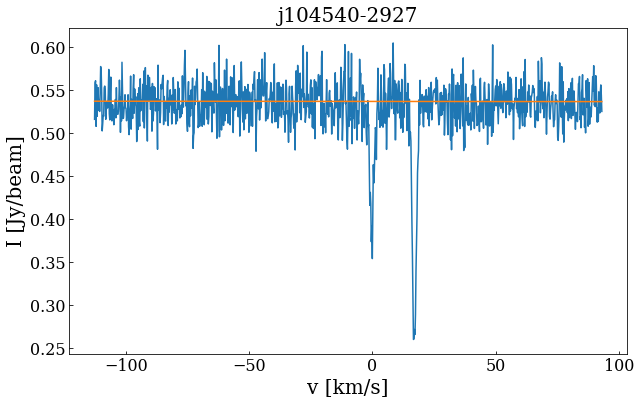

In [13]:
# fit the masked data:

pars_2 = np.polyfit(vel_masked, spectrum_masked, 1)
print(pars_2)

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j104540-2927', fontsize=20)
plt.plot(vel/1000, spectrum)
plt.plot(vel/1000, vel*pars_2[0]+pars_2[1])
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'I [Jy/beam]', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

In [14]:
# Comparing the results of the two fits:

print('Simple fit:', pars)
print('Masked fit:', pars_2)

Simple fit: [-3.03314661e-08  5.30486135e-01]
Masked fit: [-2.23061572e-09  5.36895071e-01]


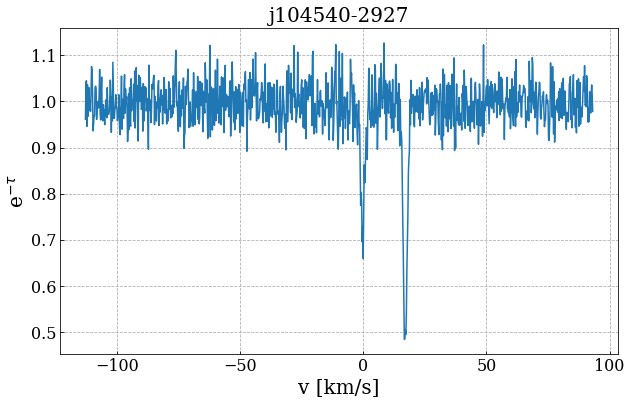

In [15]:
# Now we can devide the spectra wit the fitted continuum emission
spectra_etau = spectrum/pars_2[1]

# method 2:
continuum = spectrum*pars_2[0]+pars_2[1]
spectra_etau_2 = spectrum/continuum

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j104540-2927', fontsize=20)
plt.grid(True, linestyle = '--')
#plt.plot(spectra['velocity'],spectra_etau)
plt.plot(vel/1000,spectra_etau_2)
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'e$^{-\tau}$', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

## Smoothing the data



In [79]:
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

kernel = Gaussian1DKernel(2)
spectra_etau_smooth = convolve(spectra_etau_2, kernel)

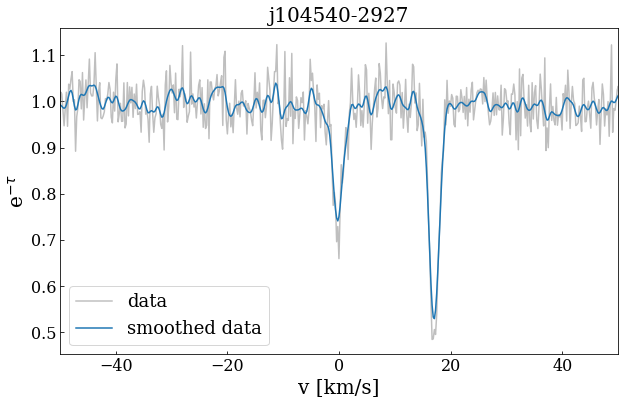

In [80]:
fig, ax=plt.subplots(figsize = (10,6))
plt.title('j104540-2927', fontsize=20)
plt.plot(vel/1000, spectra_etau_2, label='data', color='grey', alpha=0.5)
plt.plot(vel/1000, spectra_etau_smooth, label='smoothed data', color='C0')

ax.set_xlim(-50, 50)
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'e$^{-\tau}$', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=18)
plt.show()

## Find the location of the absorption peaks using the 2nd derivative of the spectra

1st derivative -> min and max at the edges of the line

2nd derivativ -> max. at the peak of the lines

In [81]:
grad_1 = np.gradient(spectra_etau_smooth)
grad_2 = np.gradient(np.gradient(spectra_etau_smooth))

print(np.where(np.max(grad_2) == grad_2))
loc = int(np.where(np.max(grad_2) == grad_2)[0])
print(vel[loc])

(array([629]),)
16876.318527765005


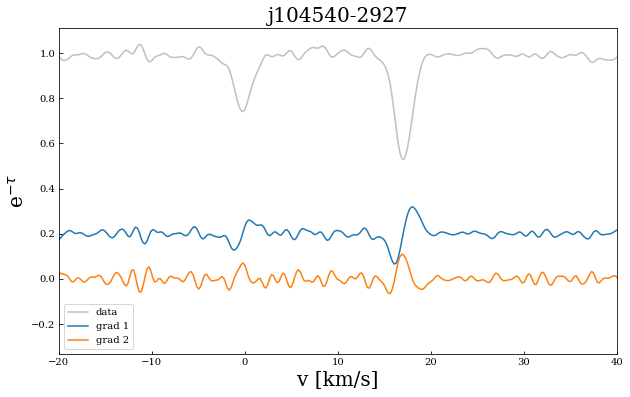

In [82]:
fig, ax=plt.subplots(figsize = (10,6))
plt.title('j104540-2927', fontsize=20)
plt.plot(vel/1000, spectra_etau_smooth, label='data', color='grey', alpha=0.5)
plt.plot(vel/1000, grad_1*2+0.2, label='grad 1', color='C0')
plt.plot(vel/1000, grad_2*5, label='grad 2', color='C1')

plt.legend()
ax.set_xlim(-20, 40)
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'e$^{-\tau}$', fontsize=20)
plt.show()